# Working with the pipeline

In [1]:
import os
os.chdir('..')

In [3]:
import datajoint as dj
import numpy as np
import matplotlib.pyplot as plt

In [4]:
dj.conn().connect()

In [5]:
animal = dj.create_virtual_module('animal', 'prod_mlims_data')
reference = dj.create_virtual_module('reference', 'group_shared_reference')
acquisition = dj.create_virtual_module('acquisition', 'group_shared_acquisition')
tracking = dj.create_virtual_module('tracking', 'group_shared_tracking')
behavior = dj.create_virtual_module('behavior', 'group_shared_behavior')
ephys = dj.create_virtual_module('ephys', 'group_shared_ephys')
analysis = dj.create_virtual_module('analysis', 'group_shared_analysis')
analysis_param = dj.create_virtual_module('analysis_param', 'group_shared_analysis_param')

# The core components of the pipeline that you probably care about the most

## The Session, Ephys Recordings, Clustering part

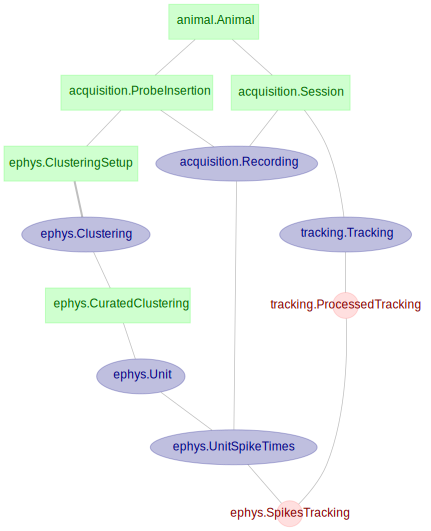

In [29]:
(dj.Diagram(animal.Animal) + tracking.Tracking + ephys.ClusteringSetup + ephys.CuratedClustering
 + ephys.SpikesTracking + ephys.Unit + acquisition.ProbeInsertion + acquisition.Recording)

## The Task, Tracking and Ephys data processing part

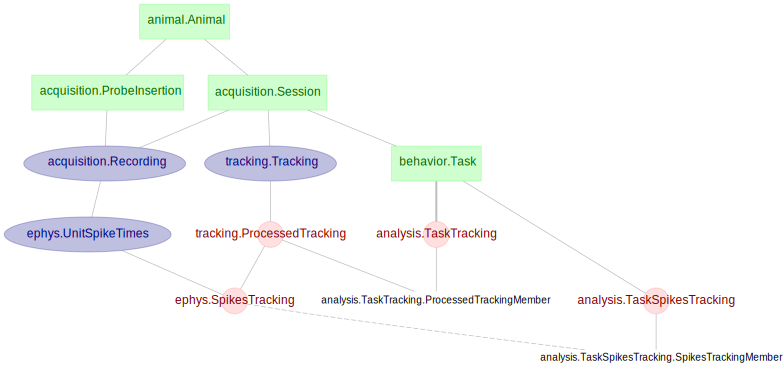

In [35]:
(dj.Diagram(animal.Animal) + tracking.Tracking + behavior.Task
 + ephys.SpikesTracking + acquisition.ProbeInsertion + acquisition.Recording
 + analysis.TaskSpikesTracking.SpikesTrackingMember
 + analysis.TaskTracking.ProcessedTrackingMember)

## The downstream analysis part

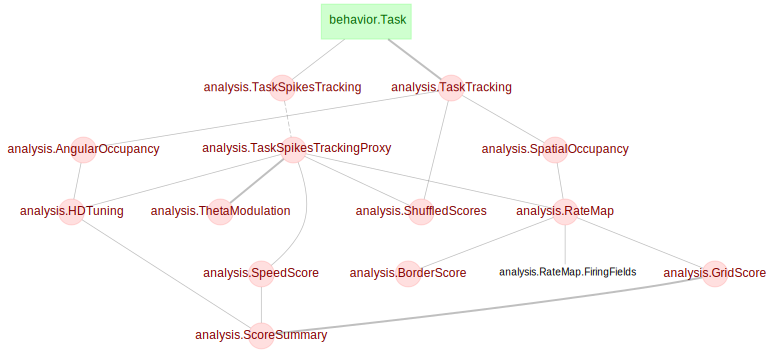

In [39]:
(dj.Diagram(analysis.TaskSpikesTrackingProxy) + 3) + analysis.TaskSpikesTracking + behavior.Task + analysis.SpatialOccupancy + analysis.AngularOccupancy

# Query and fetch your data

#### First, pick your session

In [6]:
acquisition.Session * animal.Animal

animal_id,datasource_id,session_time start time of this session,session_note,animal_species,animal_name,animal_sex,animal_dob,color,animal_notes
381970b6b65ad10d,0,2020-12-14 14:58:34,figure-eight,rat,26966,M,2020-09-15,Unknown,"Cedar, Npx2, LEC, RH"
381970b6b65ad10d,0,2020-12-14 15:18:10,open field; novel object,rat,26966,M,2020-09-15,Unknown,"Cedar, Npx2, LEC, RH"
381970b6b65ad10d,0,2020-12-14 16:26:40,,rat,26966,M,2020-09-15,Unknown,"Cedar, Npx2, LEC, RH"
381970b6b65ad10d,0,2020-12-15 08:38:48,,rat,26966,M,2020-09-15,Unknown,"Cedar, Npx2, LEC, RH"
381970b6b65ad10d,0,2020-12-15 10:56:37,open field; object,rat,26966,M,2020-09-15,Unknown,"Cedar, Npx2, LEC, RH"
381970b6b65ad10d,0,2020-12-15 11:47:50,figure-eight,rat,26966,M,2020-09-15,Unknown,"Cedar, Npx2, LEC, RH"
381970b6b65ad10d,0,2020-12-16 07:19:14,sleep,rat,26966,M,2020-09-15,Unknown,"Cedar, Npx2, LEC, RH"


In [7]:
session_key = (acquisition.Session * animal.Animal & 'animal_name = 26966' & 'session_time = "2020-12-15 10:56:37"').fetch1('KEY')

In [8]:
session_key

{'animal_id': '381970b6b65ad10d',
 'datasource_id': 0,
 'session_time': datetime.datetime(2020, 12, 15, 10, 56, 37)}

#### Next, pick your curated clustering
(Multiple rounds of clustering/curations may exist for one session data)

In [9]:
ephys.CuratedClustering * acquisition.ClusterSessionGroup.GroupMember & session_key

animal_id,datasource_id,insertion_time When this probe was inserted,group_name,time_window_name unique name for this window set,"cluster_param_name some unique name, ideally reflecting the method as well","probe_model nick name, or other user-friendly model name of this probe",electrode_config_id hash of the group and group_member (ensure uniqueness),sync_method sync method name,curation_timestamps ensure complete datetime here to prevent collision (in the rare case of multiple people curate at the exact same datetime),session_time start time of this session,curator,curation_notes,"repository e.g. 'Local', 'Network'",curation_output_dir
381970b6b65ad10d,0,2020-12-14 11:00:00,det_e3049950eb42e5564a22df89f285c03c,full_c836fc6ffbce8f5c,default_kilosort,neuropixels 2.0 - MS,60bc650acdbe48492c8fb6567ba32c82,linear_interp,2020-12-15 15:12:00,2020-12-15 10:56:37,benjamka,raw KS,spacetime,time/26966_Cedar/2020-12-15_10-53-59/probe_1/ks2.1_01
381970b6b65ad10d,0,2020-12-14 11:00:00,det_e3049950eb42e5564a22df89f285c03c,full_c836fc6ffbce8f5c,default_kilosort,neuropixels 2.0 - MS,60bc650acdbe48492c8fb6567ba32c82,linear_interp,2021-01-26 17:28:00,2020-12-15 10:56:37,benjamka,raw KS2.5 standard_low,spacetime,time/26966_Cedar/2020-12-15_10-53-59/probe_1/ks2.5_01


In [18]:
curation_key = (ephys.CuratedClustering * acquisition.ClusterSessionGroup.GroupMember & session_key
                & 'insertion_time = "2020-12-14 11:00:00"'
                & 'curation_timestamps = "2021-01-26 17:28:00"').fetch1('KEY')

In [11]:
curation_key

{'animal_id': '381970b6b65ad10d',
 'datasource_id': 0,
 'insertion_time': datetime.datetime(2020, 12, 14, 11, 0),
 'group_name': 'det_e3049950eb42e5564a22df89f285c03c',
 'time_window_name': 'full_c836fc6ffbce8f5c',
 'cluster_param_name': 'default_kilosort',
 'probe_model': 'neuropixels 2.0 - MS',
 'electrode_config_id': '60bc650acdbe48492c8fb6567ba32c82',
 'sync_method': 'linear_interp',
 'curation_timestamps': datetime.datetime(2021, 1, 26, 17, 28),
 'session_time': datetime.datetime(2020, 12, 15, 10, 56, 37)}

#### You can now use this `curation_key` as a restriction to query and fetch any data downstream, as it identifies:
+ session
+ probe
+ curated clustering

## Units, spikes, position data

+ ***ephys.UnitSpikeTimes***
+ ***tracking.ProcessedTracking***
+ ***ephys.SpikesTracking***

##### Let's look at the unit and spikes in `ephys.Unit` and `ephys.UnitSpikeTimes`

In [12]:
ephys.Unit * ephys.UnitSpikeTimes & curation_key

animal_id,datasource_id,insertion_time When this probe was inserted,group_name,time_window_name unique name for this window set,"cluster_param_name some unique name, ideally reflecting the method as well","probe_model nick name, or other user-friendly model name of this probe",electrode_config_id hash of the group and group_member (ensure uniqueness),sync_method sync method name,curation_timestamps ensure complete datetime here to prevent collision (in the rare case of multiple people curate at the exact same datetime),unit,session_time start time of this session,recording_time start time of this recording,electrode_group electrode group,electrode electrode,cluster_type,mean_firing_rate mean firing rate,spike_counts how many spikes in this recording of this unit,"unit_spike_times (s) spike times of this unit, relative to the start of the session this recording belongs to",first_spike_time (s) timestamp of the first spike (unit_spike_times[0]),last_spike_time (s) timestamp of the last spike (unit_spike_times[-1])
381970b6b65ad10d,0,2020-12-14 11:00:00,det_e3049950eb42e5564a22df89f285c03c,full_c836fc6ffbce8f5c,default_kilosort,neuropixels 2.0 - MS,60bc650acdbe48492c8fb6567ba32c82,linear_interp,2021-01-26 17:28:00,0,2020-12-15 10:56:37,2020-12-15 10:56:37,0,2609,mua,0.342877,969,=BLOB=,827.27,2811.47
381970b6b65ad10d,0,2020-12-14 11:00:00,det_e3049950eb42e5564a22df89f285c03c,full_c836fc6ffbce8f5c,default_kilosort,neuropixels 2.0 - MS,60bc650acdbe48492c8fb6567ba32c82,linear_interp,2021-01-26 17:28:00,2,2020-12-15 10:56:37,2020-12-15 10:56:37,0,2655,good,0.228231,645,=BLOB=,778.65,2811.71
381970b6b65ad10d,0,2020-12-14 11:00:00,det_e3049950eb42e5564a22df89f285c03c,full_c836fc6ffbce8f5c,default_kilosort,neuropixels 2.0 - MS,60bc650acdbe48492c8fb6567ba32c82,linear_interp,2021-01-26 17:28:00,3,2020-12-15 10:56:37,2020-12-15 10:56:37,0,3900,mua,0.0145077,41,=BLOB=,851.89,2811.27
381970b6b65ad10d,0,2020-12-14 11:00:00,det_e3049950eb42e5564a22df89f285c03c,full_c836fc6ffbce8f5c,default_kilosort,neuropixels 2.0 - MS,60bc650acdbe48492c8fb6567ba32c82,linear_interp,2021-01-26 17:28:00,6,2020-12-15 10:56:37,2020-12-15 10:56:37,0,2606,mua,0.250877,709,=BLOB=,1984.71,2014.26
381970b6b65ad10d,0,2020-12-14 11:00:00,det_e3049950eb42e5564a22df89f285c03c,full_c836fc6ffbce8f5c,default_kilosort,neuropixels 2.0 - MS,60bc650acdbe48492c8fb6567ba32c82,linear_interp,2021-01-26 17:28:00,10,2020-12-15 10:56:37,2020-12-15 10:56:37,0,8,mua,12.3506,34904,=BLOB=,0.13,2826.08
381970b6b65ad10d,0,2020-12-14 11:00:00,det_e3049950eb42e5564a22df89f285c03c,full_c836fc6ffbce8f5c,default_kilosort,neuropixels 2.0 - MS,60bc650acdbe48492c8fb6567ba32c82,linear_interp,2021-01-26 17:28:00,11,2020-12-15 10:56:37,2020-12-15 10:56:37,0,14,mua,0.924245,2612,=BLOB=,0.14,2825.54
381970b6b65ad10d,0,2020-12-14 11:00:00,det_e3049950eb42e5564a22df89f285c03c,full_c836fc6ffbce8f5c,default_kilosort,neuropixels 2.0 - MS,60bc650acdbe48492c8fb6567ba32c82,linear_interp,2021-01-26 17:28:00,12,2020-12-15 10:56:37,2020-12-15 10:56:37,0,3922,mua,0.109338,309,=BLOB=,778.92,2811.42


##### Fetch data from one unit back

In [15]:
unit_data = (ephys.Unit * ephys.UnitSpikeTimes & curation_key & 'unit = 6').fetch1()

In [16]:
unit_data 

{'animal_id': '381970b6b65ad10d',
 'datasource_id': 0,
 'insertion_time': datetime.datetime(2020, 12, 14, 11, 0),
 'group_name': 'det_e3049950eb42e5564a22df89f285c03c',
 'time_window_name': 'full_c836fc6ffbce8f5c',
 'cluster_param_name': 'default_kilosort',
 'probe_model': 'neuropixels 2.0 - MS',
 'electrode_config_id': '60bc650acdbe48492c8fb6567ba32c82',
 'sync_method': 'linear_interp',
 'curation_timestamps': datetime.datetime(2021, 1, 26, 17, 28),
 'unit': 6,
 'session_time': datetime.datetime(2020, 12, 15, 10, 56, 37),
 'recording_time': datetime.datetime(2020, 12, 15, 10, 56, 37),
 'electrode_group': 0,
 'electrode': 2606,
 'cluster_type': 'mua',
 'mean_firing_rate': 0.250877,
 'spike_counts': 709,
 'unit_spike_times': array([1984.7118    , 1984.73296667, 1990.02733333, 1990.03763333,
        1990.03786667, 1990.04633333, 1990.0469    , 1990.0489    ,
        1990.05756667, 1995.59083333, 1995.60153333, 1995.60176667,
        1995.61066667, 1996.13053333, 1996.1407    , 1996.15053

##### ProcessedTracking and SpikesTracking

In [17]:
tracking.ProcessedTracking & curation_key

animal_id,datasource_id,session_time start time of this session,tracking_time start time of this tracking recording,tracking_processing_method,sync_method sync method name,synced_tracking_start (s) timestamp of tracking onset with respect to the start of the session,synced_tracking_stop (s) timestamp of tracking offset with respect to the start of the session,"synced_tracking_timestamps (s) synced tracking timestamps, relative to the start of this session",fov_calibration_used
381970b6b65ad10d,0,2020-12-15 10:56:37,2020-12-15 10:56:32,3d_optitrack,linear_interp,-5.07,2827.71,=BLOB=,0


In [19]:
ephys.SpikesTracking & curation_key

animal_id,datasource_id,insertion_time When this probe was inserted,group_name,time_window_name unique name for this window set,"cluster_param_name some unique name, ideally reflecting the method as well","probe_model nick name, or other user-friendly model name of this probe",electrode_config_id hash of the group and group_member (ensure uniqueness),sync_method sync method name,curation_timestamps ensure complete datetime here to prevent collision (in the rare case of multiple people curate at the exact same datetime),unit,session_time start time of this session,recording_time start time of this recording,tracking_time start time of this tracking recording,tracking_processing_method,spike_times (s) repeat of SyncedSpikeTimes (for convenient queries),speed (cm/s) tracked speed at each spike times (time relative to the start of session),x_pos (cm) tracked x-pos at each spike times (time relative to the start of session),y_pos (cm) tracked y-pos at each spike times (time relative to the start of session),z_pos (cm) tracked z-pos at each spike times (time relative to the start of session),head_yaw (degree) tracked head yaw at each spike times (time relative to the start of session),head_pitch (degree) tracked head pitch at each spike times (time relative to the start of session),head_roll (degree) tracked head roll at each spike times (time relative to the start of session),angular_speed (degree/s) tracked head angular speed at each spike times (time relative to the start of session),matched_spike_percent percentage of spike times well matched to tracking times (time differences less than 2.1*tracking_fs)
381970b6b65ad10d,0,2020-12-14 11:00:00,det_e3049950eb42e5564a22df89f285c03c,full_c836fc6ffbce8f5c,default_kilosort,neuropixels 2.0 - MS,60bc650acdbe48492c8fb6567ba32c82,linear_interp,2021-01-26 17:28:00,0,2020-12-15 10:56:37,2020-12-15 10:56:37,2020-12-15 10:56:32,3d_optitrack,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,100.0
381970b6b65ad10d,0,2020-12-14 11:00:00,det_e3049950eb42e5564a22df89f285c03c,full_c836fc6ffbce8f5c,default_kilosort,neuropixels 2.0 - MS,60bc650acdbe48492c8fb6567ba32c82,linear_interp,2021-01-26 17:28:00,2,2020-12-15 10:56:37,2020-12-15 10:56:37,2020-12-15 10:56:32,3d_optitrack,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,100.0
381970b6b65ad10d,0,2020-12-14 11:00:00,det_e3049950eb42e5564a22df89f285c03c,full_c836fc6ffbce8f5c,default_kilosort,neuropixels 2.0 - MS,60bc650acdbe48492c8fb6567ba32c82,linear_interp,2021-01-26 17:28:00,3,2020-12-15 10:56:37,2020-12-15 10:56:37,2020-12-15 10:56:32,3d_optitrack,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,100.0
381970b6b65ad10d,0,2020-12-14 11:00:00,det_e3049950eb42e5564a22df89f285c03c,full_c836fc6ffbce8f5c,default_kilosort,neuropixels 2.0 - MS,60bc650acdbe48492c8fb6567ba32c82,linear_interp,2021-01-26 17:28:00,6,2020-12-15 10:56:37,2020-12-15 10:56:37,2020-12-15 10:56:32,3d_optitrack,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,100.0
381970b6b65ad10d,0,2020-12-14 11:00:00,det_e3049950eb42e5564a22df89f285c03c,full_c836fc6ffbce8f5c,default_kilosort,neuropixels 2.0 - MS,60bc650acdbe48492c8fb6567ba32c82,linear_interp,2021-01-26 17:28:00,10,2020-12-15 10:56:37,2020-12-15 10:56:37,2020-12-15 10:56:32,3d_optitrack,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,99.9628
381970b6b65ad10d,0,2020-12-14 11:00:00,det_e3049950eb42e5564a22df89f285c03c,full_c836fc6ffbce8f5c,default_kilosort,neuropixels 2.0 - MS,60bc650acdbe48492c8fb6567ba32c82,linear_interp,2021-01-26 17:28:00,11,2020-12-15 10:56:37,2020-12-15 10:56:37,2020-12-15 10:56:32,3d_optitrack,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,100.0
381970b6b65ad10d,0,2020-12-14 11:00:00,det_e3049950eb42e5564a22df89f285c03c,full_c836fc6ffbce8f5c,default_kilosort,neuropixels 2.0 - MS,60bc650acdbe48492c8fb6567ba32c82,linear_interp,2021-01-26 17:28:00,12,2020-12-15 10:56:37,2020-12-15 10:56:37,2020-12-15 10:56:32,3d_optitrack,=BLOB

## Task-related spikes and tracking data

+ ***analysis.TaskTracking***
+ ***analysis.TaskSpikesTracking***

In [21]:
behavior.Task & session_key

animal_id,datasource_id,session_time start time of this session,task_type,task_start (s) timestamp of task onset with respect to the start of the session,task_stop (s) timestamp of task offset with respect to the start of the session,arena_apparatus,task_light_level
381970b6b65ad10d,0,2020-12-15 10:56:37,Holding-Cage,798.00,845.00,flower_pot,bright
381970b6b65ad10d,0,2020-12-15 10:56:37,Holding-Cage,1940.00,2020.00,flower_pot,bright
381970b6b65ad10d,0,2020-12-15 10:56:37,OpenField,18.00,768.00,150_square,dim
381970b6b65ad10d,0,2020-12-15 10:56:37,OpenField,859.00,1922.00,150_square,dim
381970b6b65ad10d,0,2020-12-15 10:56:37,OpenField,2037.00,2800.00,150_square,dim


In [20]:
analysis.TaskTracking & curation_key

animal_id,datasource_id,session_time start time of this session,task_type,task_start (s) timestamp of task onset with respect to the start of the session,task_timestamps (s) task-related spike times (time with respect to the start of the task),speed (cm/s) task-related speed,x_pos (cm) task-related x-pos,y_pos (cm) task-related y-pos,z_pos (cm) task-related z-pos,head_yaw (degree) task-related head yaw (left/right angle),head_pitch (degree) task-related head pitch (up/down),head_roll (degree) task-related head roll (clockwise/anticlockwise),angular_speed (degree/s) task-related head angular speed
381970b6b65ad10d,0,2020-12-15 10:56:37,Holding-Cage,798.00,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
381970b6b65ad10d,0,2020-12-15 10:56:37,Holding-Cage,1940.00,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
381970b6b65ad10d,0,2020-12-15 10:56:37,OpenField,18.00,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
381970b6b65ad10d,0,2020-12-15 10:56:37,OpenField,859.00,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
381970b6b65ad10d,0,2020-12-15 10:56:37,OpenField,2037.00,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=


In [22]:
analysis.TaskSpikesTracking & curation_key

animal_id,datasource_id,session_time start time of this session,task_type,task_start (s) timestamp of task onset with respect to the start of the session,insertion_time When this probe was inserted,group_name,time_window_name unique name for this window set,"cluster_param_name some unique name, ideally reflecting the method as well","probe_model nick name, or other user-friendly model name of this probe",electrode_config_id hash of the group and group_member (ensure uniqueness),sync_method sync method name,curation_timestamps ensure complete datetime here to prevent collision (in the rare case of multiple people curate at the exact same datetime),unit,cell_selection_params_name user-friendly name,spike_times (s) task-related spike times (time with respect to the start of the task),speed (cm/s) task-related speed at each spike times,x_pos (cm) task-related x-pos at each spike times,y_pos (cm) task-related y-pos at each spike times,z_pos (cm) task-related z-pos at each spike times,head_yaw (degree) task-related head yaw (left/right angle) at each spike times,head_pitch (degree) task-related head pitch (up/down) at each spike times,head_roll (degree) task-related head roll (clockwise/anticlockwise) at each spike times,angular_speed (degree/s) task-related head angular speed at each spike times
381970b6b65ad10d,0,2020-12-15 10:56:37,Holding-Cage,798.00,2020-12-14 11:00:00,det_e3049950eb42e5564a22df89f285c03c,full_c836fc6ffbce8f5c,default_kilosort,neuropixels 2.0 - MS,60bc650acdbe48492c8fb6567ba32c82,linear_interp,2021-01-26 17:28:00,0,sleep,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
381970b6b65ad10d,0,2020-12-15 10:56:37,Holding-Cage,1940.00,2020-12-14 11:00:00,det_e3049950eb42e5564a22df89f285c03c,full_c836fc6ffbce8f5c,default_kilosort,neuropixels 2.0 - MS,60bc650acdbe48492c8fb6567ba32c82,linear_interp,2021-01-26 17:28:00,0,sleep,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
381970b6b65ad10d,0,2020-12-15 10:56:37,Holding-Cage,1940.00,2020-12-14 11:00:00,det_e3049950eb42e5564a22df89f285c03c,full_c836fc6ffbce8f5c,default_kilosort,neuropixels 2.0 - MS,60bc650acdbe48492c8fb6567ba32c82,linear_interp,2021-01-26 17:28:00,2,sleep,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
381970b6b65ad10d,0,2020-12-15 10:56:37,Holding-Cage,1940.00,2020-12-14 11:00:00,det_e3049950eb42e5564a22df89f285c03c,full_c836fc6ffbce8f5c,default_kilosort,neuropixels 2.0 - MS,60bc650acdbe48492c8fb6567ba32c82,linear_interp,2021-01-26 17:28:00,3,sleep,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
381970b6b65ad10d,0,2020-12-15 10:56:37,OpenField,859.00,2020-12-14 11:00:00,det_e3049950eb42e5564a22df89f285c03c,full_c836fc6ffbce8f5c,default_kilosort,neuropixels 2.0 - MS,60bc650acdbe48492c8fb6567ba32c82,linear_interp,2021-01-26 17:28:00,3,walk_filter_ben,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
381970b6b65ad10d,0,2020-12-15 10:56:37,Holding-Cage,1940.00,2020-12-14 11:00:00,det_e3049950eb42e5564a22df89f285c03c,full_c836fc6ffbce8f5c,default_kilosort,neuropixels 2.0 - MS,60bc650acdbe48492c8fb6567ba32c82,linear_interp,2021-01-26 17:28:00,6,sleep,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
381970b6b65ad10d,0,2020-12-15 10:56:37,Holding-Cage,798.00,2020-12-14 11:00:00,det_e3049950eb42e5564a22df89f285c03c,full_c836fc6ffbce8f5c,default_kilosort,neuropixels 2.0 - MS,60bc650acdbe48492c8fb6567ba32c82,linear_interp,2021-01-26 17:28:00,10,sleep,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=


#### Why so many entries?

These are the entries for all:
+ task
+ units
+ CellAnalysisMethod

-> need to restrict down to one `CellAnalysisMethod` of interest

#### Build a restriction for CellAnalysisMethod

In [24]:
paramsets = (analysis_param.CellAnalysisMethod.CellSelectionParams
             * analysis_param.CellAnalysisMethod.FieldDetectParams
             * analysis_param.CellAnalysisMethod.OccupancyParams
             * analysis_param.CellAnalysisMethod.SmoothingParams 
             * analysis_param.CellAnalysisMethod.ScoreParams 
             * analysis_param.CellAnalysisMethod.ShuffleParams)

In [27]:
my_paramset = paramsets & 'cell_analysis_method = "default"'

In [28]:
analysis.TaskSpikesTracking & curation_key & my_paramset & 'task_start = 859'

animal_id,datasource_id,session_time start time of this session,task_type,task_start (s) timestamp of task onset with respect to the start of the session,insertion_time When this probe was inserted,group_name,time_window_name unique name for this window set,"cluster_param_name some unique name, ideally reflecting the method as well","probe_model nick name, or other user-friendly model name of this probe",electrode_config_id hash of the group and group_member (ensure uniqueness),sync_method sync method name,curation_timestamps ensure complete datetime here to prevent collision (in the rare case of multiple people curate at the exact same datetime),unit,cell_selection_params_name user-friendly name,spike_times (s) task-related spike times (time with respect to the start of the task),speed (cm/s) task-related speed at each spike times,x_pos (cm) task-related x-pos at each spike times,y_pos (cm) task-related y-pos at each spike times,z_pos (cm) task-related z-pos at each spike times,head_yaw (degree) task-related head yaw (left/right angle) at each spike times,head_pitch (degree) task-related head pitch (up/down) at each spike times,head_roll (degree) task-related head roll (clockwise/anticlockwise) at each spike times,angular_speed (degree/s) task-related head angular speed at each spike times
381970b6b65ad10d,0,2020-12-15 10:56:37,OpenField,859.00,2020-12-14 11:00:00,det_e3049950eb42e5564a22df89f285c03c,full_c836fc6ffbce8f5c,default_kilosort,neuropixels 2.0 - MS,60bc650acdbe48492c8fb6567ba32c82,linear_interp,2021-01-26 17:28:00,10,default,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
381970b6b65ad10d,0,2020-12-15 10:56:37,OpenField,859.00,2020-12-14 11:00:00,det_e3049950eb42e5564a22df89f285c03c,full_c836fc6ffbce8f5c,default_kilosort,neuropixels 2.0 - MS,60bc650acdbe48492c8fb6567ba32c82,linear_interp,2021-01-26 17:28:00,11,default,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
381970b6b65ad10d,0,2020-12-15 10:56:37,OpenField,859.00,2020-12-14 11:00:00,det_e3049950eb42e5564a22df89f285c03c,full_c836fc6ffbce8f5c,default_kilosort,neuropixels 2.0 - MS,60bc650acdbe48492c8fb6567ba32c82,linear_interp,2021-01-26 17:28:00,13,default,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
381970b6b65ad10d,0,2020-12-15 10:56:37,OpenField,859.00,2020-12-14 11:00:00,det_e3049950eb42e5564a22df89f285c03c,full_c836fc6ffbce8f5c,default_kilosort,neuropixels 2.0 - MS,60bc650acdbe48492c8fb6567ba32c82,linear_interp,2021-01-26 17:28:00,14,default,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
381970b6b65ad10d,0,2020-12-15 10:56:37,OpenField,859.00,2020-12-14 11:00:00,det_e3049950eb42e5564a22df89f285c03c,full_c836fc6ffbce8f5c,default_kilosort,neuropixels 2.0 - MS,60bc650acdbe48492c8fb6567ba32c82,linear_interp,2021-01-26 17:28:00,16,default,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
381970b6b65ad10d,0,2020-12-15 10:56:37,OpenField,859.00,2020-12-14 11:00:00,det_e3049950eb42e5564a22df89f285c03c,full_c836fc6ffbce8f5c,default_kilosort,neuropixels 2.0 - MS,60bc650acdbe48492c8fb6567ba32c82,linear_interp,2021-01-26 17:28:00,17,default,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
381970b6b65ad10d,0,2020-12-15 10:56:37,OpenField,859.00,2020-12-14 11:00:00,det_e3049950eb42e5564a22df89f285c03c,full_c836fc6ffbce8f5c,default_kilosort,neuropixels 2.0 - MS,60bc650acdbe48492c8fb6567ba32c82,linear_interp,2021-01-26 17:28:00,18,default,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=


In [44]:
unit_data = (analysis.TaskSpikesTracking & curation_key & my_paramset & 'task_start = 859' & 'unit = 10').fetch1()

In [45]:
unit_data

{'animal_id': '381970b6b65ad10d',
 'datasource_id': 0,
 'session_time': datetime.datetime(2020, 12, 15, 10, 56, 37),
 'task_type': 'OpenField',
 'task_start': Decimal('859.00'),
 'insertion_time': datetime.datetime(2020, 12, 14, 11, 0),
 'group_name': 'det_e3049950eb42e5564a22df89f285c03c',
 'time_window_name': 'full_c836fc6ffbce8f5c',
 'cluster_param_name': 'default_kilosort',
 'probe_model': 'neuropixels 2.0 - MS',
 'electrode_config_id': '60bc650acdbe48492c8fb6567ba32c82',
 'sync_method': 'linear_interp',
 'curation_timestamps': datetime.datetime(2021, 1, 26, 17, 28),
 'unit': 10,
 'cell_selection_params_name': 'default',
 'spike_times': array([2.05433333e-01, 2.39966667e-01, 2.51233333e-01, ...,
        1.06289223e+03, 1.06293443e+03, 1.06295090e+03]),
 'speed': array([ 4.85655111,  6.84135454,  4.79027906, ..., 28.26984814,
        33.54641974, 30.75751833]),
 'x_pos': array([26.82483864, 26.91633034, 26.90737915, ..., 18.37238503,
        17.16115189, 16.79920769]),
 'y_pos': arr

## The analysis tables

Basically, the pattern is, pick your analysis table of interest (e.g. ratemap), join with `analysis.TaskSpikesTrackingProxy`, then followed by the restrictions (e.g. `curation_key`, or task, or unit, etc.)

In [46]:
analysis.RateMap * analysis.TaskSpikesTrackingProxy & curation_key & my_paramset & 'task_start = 859' & 'unit = 10'

animal_id animal,datasource_id animal,session_time start time of this session,unit unit id,task_type,task_start (s) timestamp of task onset with respect to the start of the session,task_spike_tracking_hash hash of the TaskSpikesTracking primary_key,"occu_params_name Parameter set ID, starting with 'default'",smoothing_params_name,analysis_package,cell_selection_params_name user-friendly name,"field_detect_params_name Field detection method name, starting with A",ratemap Smoothed 2D ratemap,ratemap_mask Mask (where time = 0),ratemap_raw Unsmoothed ratemap,fieldmap,field_quantity,peak_rate,mean_rate 4,spatial_information_rate 3 information.rate,spatial_information_content 3 information.content,spatial_coherence 5 coherence,selectivity 3 selectivity,sparsity 5 sparsity,is_padded Is the arena padded?,version_ratemap,insertion_time When this probe was inserted,group_name,time_window_name unique name for this window set,"cluster_param_name some unique name, ideally reflecting the method as well","probe_model nick name, or other user-friendly model name of this probe",electrode_config_id hash of the group and group_member (ensure uniqueness),sync_method sync method name,curation_timestamps ensure complete datetime here to prevent collision (in the rare case of multiple people curate at the exact same datetime)
381970b6b65ad10d,0,2020-12-15 10:56:37,10,OpenField,859.00,a5eadef5b5e107d6048bcfafb390720e,default,default,python,default,default,=BLOB=,=BLOB=,=BLOB=,=BLOB=,0,19.4774,8.85256,1.27873,0.142169,0.278261,2.1655,0.952641,0,Opexebo v0.5.0,2020-12-14 11:00:00,det_e3049950eb42e5564a22df89f285c03c,full_c836fc6ffbce8f5c,default_kilosort,neuropixels 2.0 - MS,60bc650acdbe48492c8fb6567ba32c82,linear_interp,2021-01-26 17:28:00


In [34]:
analysis.GridScore * analysis.SpeedScore * analysis.TaskSpikesTrackingProxy & curation_key & my_paramset & 'task_start = 859' & 'unit = 10'

animal_id animal,datasource_id animal,session_time start time of this session,unit unit id,task_type,task_start (s) timestamp of task onset with respect to the start of the session,task_spike_tracking_hash hash of the TaskSpikesTracking primary_key,"occu_params_name Parameter set ID, starting with 'default'",smoothing_params_name,analysis_package,cell_selection_params_name user-friendly name,"field_detect_params_name Field detection method name, starting with A",score_params_name,auto_corr 2D autocorrelogram of smoothed ratemap,grid_score Grid score,grid_spacings (cm) Distance from central pixel to centre of 3 firing fields used for ellipse calculation,grid_orientations (degrees) Angle of 3 firing fields used for ellipse calculation,grid_ellipse Parameters of fitted ellipse,grid_ellipse_theta (degrees) Angle of ellipse major axis,grid_ellipse_aspect_ratio Ratio of ellipse major to minor axis length,version_grid_score e.g. opexebo_1.0.0,speed_score,version_speed_score e.g. opexebo_1.0.0,insertion_time When this probe was inserted,group_name,time_window_name unique name for this window set,"cluster_param_name some unique name, ideally reflecting the method as well","probe_model nick name, or other user-friendly model name of this probe",electrode_config_id hash of the group and group_member (ensure uniqueness),sync_method sync method name,curation_timestamps ensure complete datetime here to prevent collision (in the rare case of multiple people curate at the exact same datetime)
381970b6b65ad10d,0,2020-12-15 10:56:37,10,OpenField,859.00,a5eadef5b5e107d6048bcfafb390720e,default,default,python,default,default,default,=BLOB=,-0.427567,=BLOB=,=BLOB=,=BLOB=,209.308,1.01805,Opexebo v0.5.0,0.0417654,Opexebo v0.5.0,2020-12-14 11:00:00,det_e3049950eb42e5564a22df89f285c03c,full_c836fc6ffbce8f5c,default_kilosort,neuropixels 2.0 - MS,60bc650acdbe48492c8fb6567ba32c82,linear_interp,2021-01-26 17:28:00


##### Fetch only the attributes of interest

In [38]:
task_spikes_x, task_spikes_y = (analysis.TaskSpikesTracking & curation_key & my_paramset & 'task_start = 859' & 'unit = 10').fetch1('x_pos', 'y_pos')

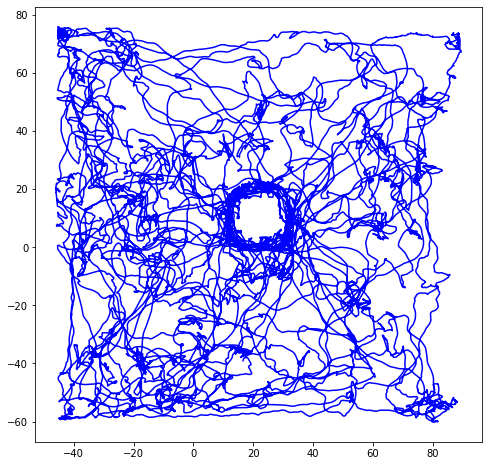

In [43]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(task_x, task_y, '-b')

In [40]:
task_x, task_y = (analysis.TaskTracking & curation_key & my_paramset & 'task_start = 859').fetch1('x_pos', 'y_pos')

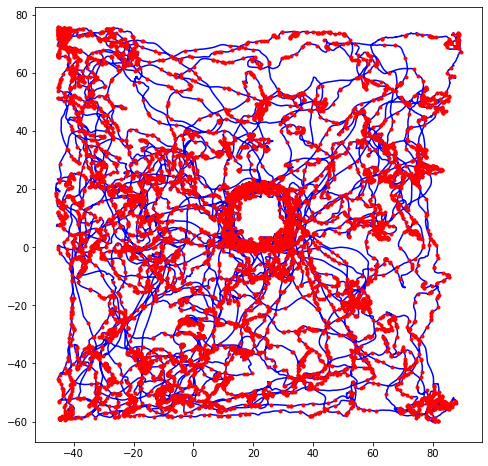

In [42]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(task_x, task_y, '-b')
ax.plot(task_spikes_x, task_spikes_y, '.r')

In [35]:
unit_id, ratemap = (analysis.RateMap * analysis.TaskSpikesTrackingProxy & curation_key & my_paramset & 'task_start = 859' & 'unit = 10').fetch1('unit', 'ratemap')

In [37]:
unit_id

10

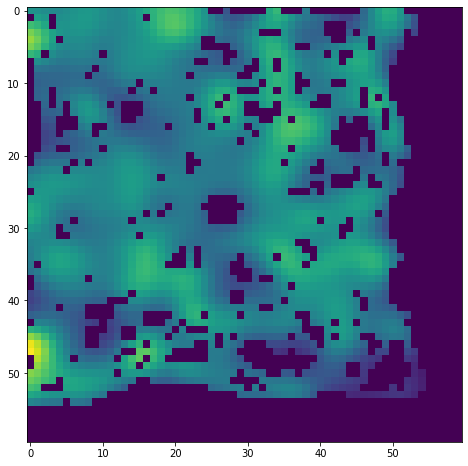

In [47]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.imshow(ratemap)